<a href="https://colab.research.google.com/github/Arbarbn/song-popularity-kaggle-competition/blob/main/song_popularity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arbarobbani","key":"57c5e10f0dd3953ce6a01de50df52d26"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c song-popularity-prediction

  0% 0.00/3.33M [00:00<?, ?B/s]
100% 3.33M/3.33M [00:00<00:00, 109MB/s]
  0% 0.00/849k [00:00<?, ?B/s]
100% 849k/849k [00:00<00:00, 122MB/s]
  0% 0.00/67.3k [00:00<?, ?B/s]
100% 67.3k/67.3k [00:00<00:00, 69.3MB/s]


In [ ]:
! mkdir train
! unzip train.csv.zip -d train

Archive:  train.csv.zip
  inflating: train/train.csv         


In [ ]:
! mkdir test
! unzip test.csv.zip -d test

Archive:  test.csv.zip
  inflating: test/test.csv           


What will do? 
- Classify song is popular or not (Binary classification)

Steps (CRISP-DM) :
1. **data understanding** : statistics, null, correlation, distribution
2. **data preparation** : feature engineering -> filling NaN value, handle distribution
3. **modeling** : XGBOOST 
4. **evaluation** : if balance, we use classification_report from sklearn if imbalance, we use imbalance_classification_report from imblearn
5. **deployment** : prepare submit file and push into kaggle

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
df = pd.read_csv('/content/train/train.csv')
df.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0


Data understanding

In [ ]:
df.describe()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
count,40000.00000,35899.000000,36008.000000,35974.000000,36025.000000,36015.000000,35935.000000,35914.000000,36043.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,19999.50000,193165.847572,0.276404,0.570951,0.683932,0.036527,5.042605,0.198514,-7.407596,0.321150,0.094107,116.562815,3.394375,0.580645,0.364400
std,11547.14972,45822.127679,0.297928,0.190010,0.212662,0.150024,3.372728,0.151670,3.877198,0.466924,0.083591,26.167911,0.524405,0.237351,0.481268
min,0.00000,25658.000000,-0.013551,0.043961,-0.001682,-0.004398,0.000000,0.027843,-32.117911,0.000000,0.015065,62.055779,2.000000,0.013398,0.000000
25%,9999.75000,166254.500000,0.039618,0.424760,0.539276,0.000941,2.000000,0.111796,-9.578139,0.000000,0.038500,96.995309,3.000000,0.398669,0.000000
50%,19999.50000,186660.000000,0.140532,0.608234,0.704453,0.001974,5.000000,0.135945,-6.345413,0.000000,0.055881,113.795959,3.000000,0.598827,0.000000
75%,29999.25000,215116.000000,0.482499,0.718464,0.870503,0.003225,8.000000,0.212842,-4.620711,1.000000,0.118842,128.517383,4.000000,0.759635,1.000000
max,39999.00000,491671.000000,1.065284,0.957131,1.039741,1.075415,11.000000,1.065298,-0.877346,1.000000,0.560748,219.163578,5.000000,1.022558,1.000000


In [ ]:
df.isnull().sum()

id                     0
song_duration_ms    4101
acousticness        3992
danceability        4026
energy              3975
instrumentalness    3985
key                 4065
liveness            4086
loudness            3957
audio_mode             0
speechiness            0
tempo                  0
time_signature         0
audio_valence          0
song_popularity        0
dtype: int64

In [ ]:
df['song_popularity'].unique()

array([0, 1])

In [ ]:
popular = df[df.song_popularity==1].shape[0]
unpopular = df[df.song_popularity==0].shape[0]
print("Number of popular song in training:", str(round(popular*100/df.shape[0], 2))+"%")
print("Number of unpopular song in training:", str(round(unpopular*100/df.shape[0], 2))+"%")

Number of popular song in training: 36.44%
Number of unpopular song in training: 63.56%


This shows that data is imbalance with number of unpopular more than popular song.

Distribution Class -> Imbalance 64 : 36

Text(0.5, 1.0, 'Distribution Class \n 0 : unpopular | 1 : popular')

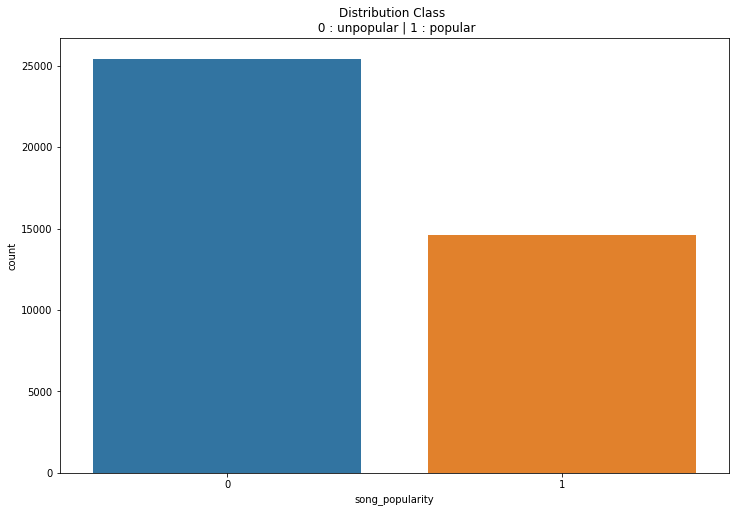

In [ ]:
f, ax = plt.subplots(figsize=(12,8))
sns.countplot(x='song_popularity', data=df, ax=ax)
ax.set_title('Distribution Class \n 0 : unpopular | 1 : popular')

Correlation

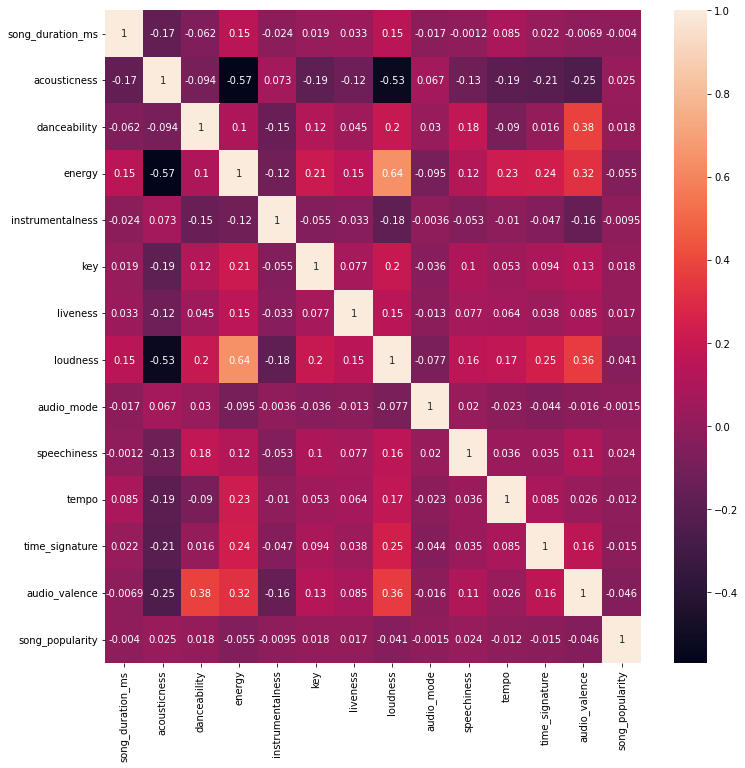

In [ ]:
_, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df.drop('id', axis=1).corr(), annot=True, ax = ax)

From heatmap, we can conclude feature energy and loudness has positive high correlation and negative high correlation between acousticness and loudness and between acousticness and energy .in this heatmap, there are no correlation feature with target class. But, if we look at higher correlation we get energy, audio_valence, loudness 😢😢😢😢😢

Distribution per feature to target class

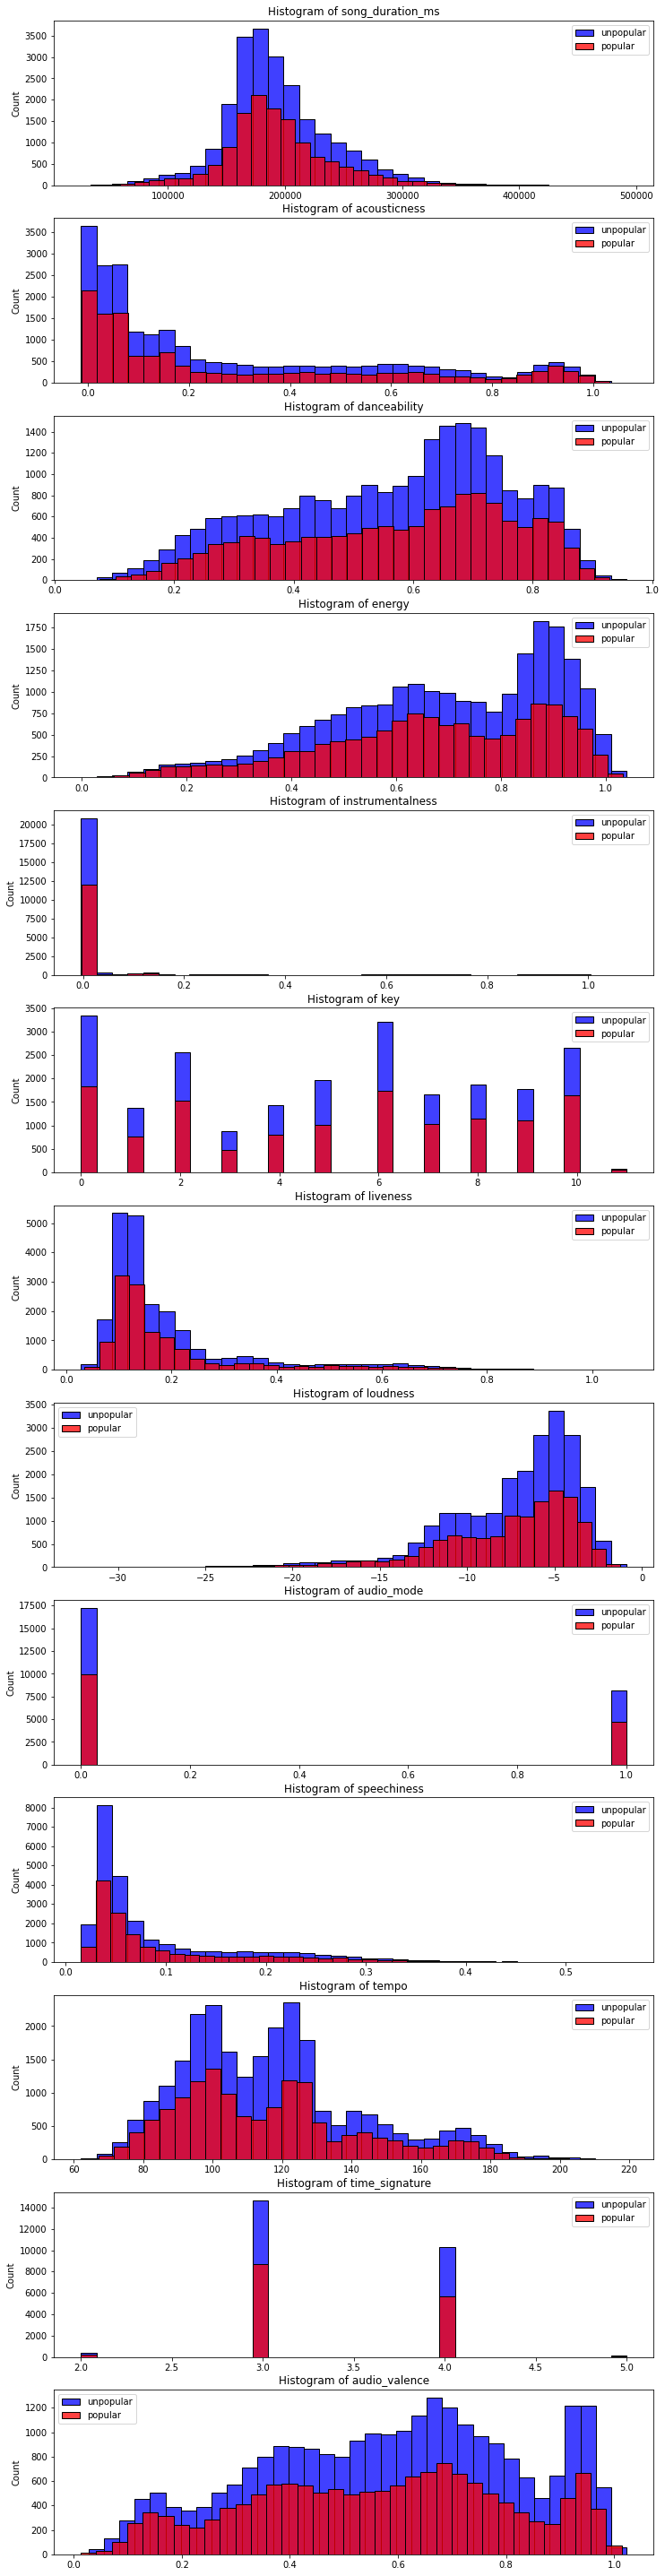

In [ ]:
from matplotlib import gridspec 

v_features = df.drop(['song_popularity', 'id'], axis=1).columns
plt.figure(figsize=(12, 13*4))
gs = gridspec.GridSpec(13,1)
for i, cn in enumerate(df[v_features]):
  ax = plt.subplot(gs[i])
  sns.histplot(df[cn][df.song_popularity==0], color='blue', bins=35)
  sns.histplot(df[cn][df.song_popularity==1], color='red', bins=35)
  ax.set_xlabel('')
  ax.set_title('Histogram of '+str(cn))
  ax.legend(['unpopular', 'popular'])
plt.show()

In [ ]:
df[df.song_popularity==1].describe()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
count,14576.000000,13093.000000,13149.000000,13050.000000,13173.000000,13156.000000,13118.000000,13075.000000,13137.000000,14576.000000,14576.000000,14576.000000,14576.000000,14576.000000,14576.0
mean,19952.620472,192926.389521,0.286342,0.575376,0.668628,0.034646,5.121817,0.201835,-7.615769,0.320252,0.096781,116.155018,3.384193,0.566373,1.0
std,11574.629212,45622.433532,0.308891,0.190052,0.214797,0.145207,3.392557,0.155449,3.996839,0.466589,0.085458,26.651180,0.519303,0.236396,0.0
min,1.000000,33994.000000,-0.012245,0.049807,0.002322,-0.003854,0.000000,0.034597,-30.170399,0.000000,0.015153,62.889002,2.000000,0.013398,1.0
25%,9897.500000,167210.000000,0.040459,0.427033,0.529351,0.000867,2.000000,0.113356,-9.897729,0.000000,0.039289,96.085274,3.000000,0.384517,1.0
50%,19901.500000,187350.000000,0.139611,0.611323,0.684349,0.001902,6.000000,0.136270,-6.555986,0.000000,0.057684,112.222666,3.000000,0.581656,1.0
75%,29999.250000,213717.000000,0.505333,0.725616,0.857799,0.003231,8.000000,0.211746,-4.679423,1.000000,0.123746,128.871533,4.000000,0.741884,1.0
max,39997.000000,470577.000000,1.062516,0.954945,1.033747,1.064847,11.000000,1.028600,-1.218480,1.000000,0.533257,215.861368,5.000000,1.013484,1.0


In [ ]:
df[df.song_popularity==0].describe()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
count,25424.000000,22806.000000,22859.000000,22924.000000,22852.000000,22859.000000,22817.000000,22839.000000,22906.000000,25424.000000,25424.000000,25424.000000,25424.000000,25424.000000,25424.0
mean,20026.376809,193303.321231,0.270688,0.568432,0.692754,0.037609,4.997064,0.196612,-7.288205,0.321665,0.092573,116.796612,3.400212,0.588827,0.0
std,11531.507655,45936.814889,0.291289,0.189945,0.210922,0.152720,3.360504,0.149434,3.801833,0.467124,0.082464,25.884407,0.527229,0.237515,0.0
min,0.000000,25658.000000,-0.013551,0.043961,-0.001682,-0.004398,0.000000,0.027843,-32.117911,0.000000,0.015065,62.055779,2.000000,0.027657,0.0
25%,10070.750000,165677.000000,0.039132,0.423877,0.545368,0.000989,2.000000,0.110872,-9.387710,0.000000,0.038097,97.493855,3.000000,0.408112,0.0
50%,20065.500000,186261.500000,0.140956,0.606252,0.718353,0.002020,5.000000,0.135706,-6.232257,0.000000,0.054780,114.334715,3.000000,0.609070,0.0
75%,29997.250000,215940.500000,0.468349,0.714748,0.876354,0.003222,8.000000,0.213425,-4.586064,1.000000,0.116147,128.295829,4.000000,0.770013,0.0
max,39999.000000,491671.000000,1.065284,0.957131,1.039741,1.075415,11.000000,1.065298,-0.877346,1.000000,0.560748,219.163578,5.000000,1.022558,0.0


From this histogram, we cant distinguish between popular and unpopular song. We can see with same range but with different count because of the imbalance. So, we must to data preparation. 

we will look at test data to synchronize with data train

In [ ]:
df.shape

(40000, 15)

In [ ]:
X_train = df.drop(['song_popularity', 'id'], axis=1)
y_train = df['song_popularity']

In [ ]:
X_train.shape

(40000, 13)

In [ ]:
y_train.shape

(40000,)

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(missing_values=np.nan, initial_strategy="median", max_iter=70)
for y in X_train.columns:
    X_train[y] = imputer.fit_transform(X_train[[y]]).ravel()
          
X_train['song_popularity'] = df.song_popularity

In [ ]:
train = X_train.copy()

In [ ]:
train.shape

(40000, 14)

In [ ]:
train.isnull().sum()

song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
song_popularity     0
dtype: int64

In [ ]:
df_test = pd.read_csv('/content/test/test.csv')

test = df_test.drop('id', axis=1)
test.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,308523.0,0.019845,NaN,0.908939,0.001438,NaN,0.112832,-8.890172,0,0.082714,126.129304,4,0.399620
1,200011.0,0.070119,0.731256,0.444655,0.002020,10.0,0.139040,-6.301214,0,0.061685,86.448149,3,0.499424
2,279758.0,0.810637,0.568858,0.125466,0.898841,0.0,0.226614,-11.542478,0,0.041868,99.544351,3,0.564951
3,249197.0,NaN,0.871789,0.557342,0.000715,4.0,0.325391,-7.905546,1,0.046815,123.063854,4,0.906485
4,NaN,0.765568,0.624687,0.710794,0.000346,8.0,0.308284,NaN,0,0.129284,88.703121,3,0.935571


In [ ]:
for y in test.columns:
  test[y] = imputer.fit_transform(test[[y]]).ravel()

In [ ]:
test.isnull().sum()

song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X = train.drop(['song_popularity'], axis=1)
y = train['song_popularity']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size =0.2, random_state = 662)

PCA

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler =StandardScaler()
scaler.fit(X_train)

X_train_scaler = scaler.transform(X_train)
X_val_scaler = scaler.transform(X_val)

In [ ]:
from sklearn.decomposition import PCA

# we want the explained variance to be between 95%.
pca = PCA(n_components=2)
pca.fit(X_train_scaler)
pca.n_components_

In [ ]:
X_train_pca = pca.transform(X_train_scaler)
X_val_pca = pca.transform(X_val_scaler)

MODELING

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.metrics import classification_report_imbalanced

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
model = RandomForestClassifier(random_state=1772, class_weight='balanced', max_features= 'auto', n_estimators= 300)
model.fit(X_train_pca, y_train)

pred = model.predict(X_val_pca)
print(classification_report_imbalanced(y_val, pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.63      0.85      0.15      0.73      0.36      0.14      5052
          1       0.38      0.15      0.85      0.22      0.36      0.12      2948

avg / total       0.54      0.60      0.41      0.54      0.36      0.13      8000



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

params = { 'max_features':['auto', 'log2', 9], 
               'n_estimators': [100, 200, 300]}
roc_auc = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)
rf_gd=GridSearchCV(RandomForestClassifier(random_state=66), param_grid = params, verbose=True, 
                cv=3, scoring = roc_auc)
rf_gd.fit(X_train_pca, y_train)
print(rf_gd.best_score_)
print(rf_gd.best_estimator_)
print(rf_gd.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
0.5385003465290965
RandomForestClassifier(n_estimators=300, random_state=66)
{'max_features': 'auto', 'n_estimators': 300}


In [ ]:
from sklearn.metrics import roc_auc_score

pred = rf_gd.predict(X_val_pca)
print("AUC score:", roc_auc_score(y_val, pred))

AUC score: 0.5039639311539903


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

params = {'algorithm': ['auto'], 'weights': ['uniform', 'distance'], 'leaf_size': list(range(1,10,2)), 
               'n_neighbors': [100, 500]}
roc_auc = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)
knn_gd=GridSearchCV(knn, param_grid = params, verbose=True, 
                cv=3, scoring = roc_auc)
knn_gd.fit(X_train_pca, y_train)
print(knn_gd.best_score_)
print(knn_gd.best_estimator_)
print(knn_gd.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
0.5536707433991849
KNeighborsClassifier(leaf_size=1, n_neighbors=500, weights='distance')
{'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 500, 'weights': 'distance'}


In [ ]:
knn = KNeighborsClassifier(leaf_size=1, n_neighbors=300, weights='distance')
knn.fit(X_train_pca,y_train)

knn_pred = knn.predict(X_val_pca)
print(classification_report_imbalanced(y_val, pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.64      0.85      0.16      0.73      0.37      0.15      5052
          1       0.39      0.16      0.85      0.23      0.37      0.13      2948

avg / total       0.54      0.60      0.42      0.54      0.37      0.14      8000



In [ ]:
from sklearn.metrics import roc_auc_score

print("AUC score:", roc_auc_score(y_val, knn_gd.predict(X_val_pca)))

AUC score: 0.5


Deployment

In [ ]:
X_scaler = scaler.transform(X)
X_pca = pca.transform(X_scaler)

In [ ]:
knn = KNeighborsClassifier(leaf_size=1, n_neighbors=300, weights='distance')
knn.fit(X_pca, y)

KNeighborsClassifier(leaf_size=1, n_neighbors=300, weights='distance')

In [ ]:
model = RandomForestClassifier(random_state=1772, n_estimators= 200, class_weight='balanced')
model.fit(X_pca, y)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=1772)

In [ ]:
test_scaler = scaler.transform(test)
test_pca = pca.transform(test_scaler)
test_pred1 = knn.predict(test_pca)

In [ ]:
test_pred2 = model.predict(test_pca)

In [ ]:
submit = pd.DataFrame()
submit['id'] = df_test['id']
submit['song_popularity']=test_pred1
submit.head()

,id,song_popularity
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
submit['song_popularity'].value_counts()

0    9973
1      27
Name: song_popularity, dtype: int64

In [ ]:
submit.to_csv("submission.csv", index = False)